# AEGAN datasets benchmark

In [88]:
import pandas as pd
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/')
from enzymetk.sequence_search_blast import BLAST
from enzymetk.save_step import Save
from sciutil import SciUtil 

u = SciUtil()

# Basically want to run blast on each of the datasets and see how many get the correct active site
# We do this filtering first to remove them from the sequence set
data_dir = '/disk1/ariane/vscode/squidly/aegan_structures/AEGAN_extracted_sequences/'
files = os.listdir(data_dir)
swissprot = pd.read_csv('data/wills_metadata.tsv', sep='\t')
swissprot = pd.read_csv('../enzyme_datasets_benchmark/swissprot.tsv', sep='\t')
swissprot = pd.read_csv('data/reviewed_sprot_08042025.tsv', sep='\t')

def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['Residue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df
    
swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
training_ids = set(pd.read_csv('data/AEGAN_real_training_set.txt', header=None)[0].values)
training_df = swissprot[swissprot['Entry'].isin(training_ids)]

u.dp(['Number of AEGAN training set:', len(training_df)])

--------------------------------------------------------------------------------
                      Number of AEGAN training set:	9888	                       
--------------------------------------------------------------------------------


In [89]:
training_df[training_df['Residue'] == 'None']

,Entry,Length,Sequence,Active site,PDB,Residue,active_site_residue_counts


# Now for each test set we want to look for the closest sequence in the AEGAN training set 

We do this for each of the sequneces in AEGAN.

In [90]:
%%capture

for f in files:
    try:
        df = pd.read_csv(f'{data_dir}{f}/{f}.tsv', sep='\t')
        entries = set(list(df['Entry'].values))
        # Remove from SwissProt
        # Now we're going to save this as a fasta file 
        fasta_label = f'data/AEGAN/AEGAN_with_active_site_seqs_{f}.fasta'
        with open(fasta_label, 'w+') as fout:
            for entry, seq in training_df[['Entry', 'Sequence']].values:
                if entry not in entries:
                    fout.write(f'>{entry}\n{seq}\n')
        # Do blast on this dataset 
        # This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
        # This contains the models and the data needed to run the tool
        id_col = 'Entry'
        seq_col = 'Sequence'
        df << (BLAST(id_col, seq_col, database=fasta_label, args=['--ultra-sensitive']) >> Save(f'data/AEGAN/blast/{f}_BLAST.pkl'))
    except:
        print(f)
        # Use this to suppress the output of the cell... 

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/AEGAN/AEGAN_with_active_site_seqs_PC.fasta
Opening the database file...  [0.002s]
Loading sequences...  [0.016s]
Masking sequences...  [0.03s]
Writing sequences...  [0.002s]
Hashing sequences...  [0.001s]
Loading sequences...  [0s]
Writing trailer...  [0.004s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  9870
  Database letters  4032426
     Database hash  129885c69cb938b471437545d84ffcb5
        Total time  0.057000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support 

# For each of these now what we want to do is to pull out the familiies and align using the clustal omega 

In [91]:
files = os.listdir('data/AEGAN/blast/')
results = {}
for f in files:
    try:
        label = f.split('_BLAST.pkl')[0]
        df = pd.read_csv(f'{data_dir}{label}/{label}.tsv', sep='\t')
        entries = set(list(df['Entry'].values))
        blast_df = pd.read_pickle(f'data/AEGAN/blast/{f}')
        blast_df = blast_df.sort_values(by='sequence identity', ascending=False)
        blast_df.drop_duplicates('query', inplace=True)
        # Then join up with all df
        blast_df.set_index('query', inplace=True)
        df.set_index('Entry', inplace=True)
        df = df.join(blast_df, how='left')
        results[f] = df
        uniprot_id_to_seq = dict(zip(swissprot.Entry, swissprot.Sequence))
        for name, seq, uniprot in df[['From', 'Sequence', 'target']].values:
            fin = f'msa/{uniprot}_{name}.fa'
            with open(fin, 'w+') as fout:
                fout.write(f'>{uniprot}\n{uniprot_id_to_seq.get(uniprot)}\n')
                fout.write(f'>{name}\n{seq}')
            # Now run clustalomega
            os.system(f'clustalo --force -i {fin} -o {fin.replace(".fa", ".msa")}')
    except:
        print(f)

EF_family_BLAST.csv
PC_BLAST.csv
EF_fold_BLAST.csv
HA_superfamily_BLAST.csv
NN_BLAST.csv
EF_superfamily_BLAST.csv
EF_family


# Read in the datasets and annotate the residues predicted by BLAST

In [92]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Read in squidly results
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm 

def get_evaluation_metrics(actuals, predictions):
    # Calculate evaluation metrics
    TP = sum([1 for i in range(len(actuals)) if actuals[i] == 1 and predictions[i] == 1])
    TN = sum([1 for i in range(len(actuals)) if actuals[i] == 0 and predictions[i] == 0])
    FP = sum([1 for i in range(len(actuals)) if actuals[i] == 0 and predictions[i] == 1])
    FN = sum([1 for i in range(len(actuals)) if actuals[i] == 1 and predictions[i] == 0])
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    return f1, precision, recall, accuracy


def calculate_stats(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement:
    agree, disagree, none_ = 0, 0, 0
    percent_aggree = []
    to_check = []
    missing = 0
    predictions = []
    true = []
    for seq_label, res_sq, res_pred, seq in df[[id_col, true_col, pred_col, seq_col]].values:
        if not res_sq:
            missing += 1
        else:
            # Calculate the F1 score
            res_sq = res_sq.split('|')
            if not res_pred or not isinstance(res_pred, str):
                none_ += 1
                percent_aggree.append(0)
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    predictions.append(0) # Since we had no true predictions
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
            else:
                res_pred = res_pred.split('|')
                if res_sq != res_pred:
                    to_check.append(seq_label)
                    # Check the % agree 
                    percent_aggree.append(len(set(res_sq) & set(res_pred))/max(len(res_sq), len(res_pred)))
                    disagree += 1
                else:
                    percent_aggree.append(1)
                    agree += 1
                chosen_res_seq = [int(i) for i in res_pred]
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
                    if pos in chosen_res_seq:
                        predictions.append(1)
                    else:
                        predictions.append(0)
    print("You were missing N reference sequences:", missing)
    precision, recall, f1, support = precision_recall_fscore_support(true, predictions)
    f1_, precision_, recall_, accuracy_ = get_evaluation_metrics(true, predictions)
    print(f1, f1_)
    # f1, precision, recall, support, agree, disagree, no_pred, mean_agreement
    return precision[1], recall[1], f1[1], support[1], agree/len(df), disagree/len(df), none_/len(df), np.mean(percent_aggree)


In [93]:
colors = ['#FFC440', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64']
order = ['EF_family', 
         'NN',
         'HA_superfamily',
         'PC',
         'EF_fold',
         'EF_superfamily',
         ]
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (3,3)
sns.set(rc={'figure.figsize': (3,3), 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 12}, 
        style='ticks')

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax

--------------------------------------------------------------------------------
         Missing a BLAST sequence: 	20	Found with BLAST sequences:	176	         
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.9993904  0.85260116] 0.8526011560693643
--------------------------------------------------------------------------------
EF_family	
F1	0.8526011560693643	
precision:	0.913312693498452	
 recall:	0.7994579945799458	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
         Missing a BLAST sequence: 	12	Found with BLAST sequences:	96	          
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99933647 0.83240223] 0.8324022346368716
--------------------------------------------------------------------------------
NN	
F1	0

/tmp/ipykernel_18717/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")
/tmp/ipykernel_18717/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")


--------------------------------------------------------------------------------
         Missing a BLAST sequence: 	20	Found with BLAST sequences:	132	         
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99933628 0.83820663] 0.838206627680312
--------------------------------------------------------------------------------
HA_superfamily	
F1	0.838206627680312	
precision:	0.9033613445378151	
 recall:	0.7818181818181819	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
          Missing a BLAST sequence: 	2	Found with BLAST sequences:	53	          
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99947971 0.88541667] 0.8854166666666665
--------------------------------------------------------------------------------
PC	


/tmp/ipykernel_18717/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")
/tmp/ipykernel_18717/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")
/tmp/ipykernel_18717/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

--------------------------------------------------------------------------------
         Missing a BLAST sequence: 	14	Found with BLAST sequences:	109	         
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99948484 0.88135593] 0.8813559322033898
--------------------------------------------------------------------------------
EF_superfamily	
F1	0.8813559322033898	
precision:	0.9381443298969072	
 recall:	0.8310502283105022	
--------------------------------------------------------------------------------
78


/tmp/ipykernel_18717/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")


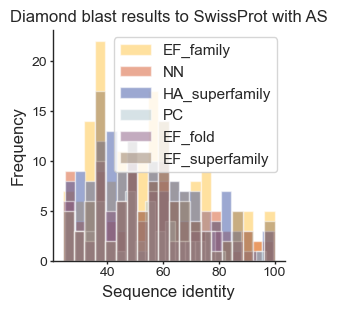

In [117]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np

# OK here we need to have all the swiss prot since we're searching fro both the test and the training to this set
# so this is just uniprot to the active sites
uniprot_id_to_active_site = dict(zip(swissprot['Entry'], swissprot['Residue']))

dataset_to_blast = {}
missing_blast_seq = pd.DataFrame()
total_missing, total_found = 0, 0

for di, df_label in enumerate(order):
    df_label = df_label + '_BLAST.pkl'
    df = results[df_label]
    predicted_active_sites = {}
    missing, found = 0, 0
    missing_entries = []
    for query, uniprot in df[['From', 'target']].values:
        if not uniprot or not isinstance(uniprot, str):
            missing += 1
            missing_entries.append(query)
        else:
            fin = f'msa/{uniprot}_{query}.msa'
            # Read with bioseq
            # Read the alignment
            active_sites = [int(x) for x in uniprot_id_to_active_site.get(uniprot).split('|')]
            alignment = AlignIO.read(fin, 'fasta')
            # get the existing one and then calculate the position gapped
            records = {}
            for record in alignment:
                records[record.id] = record.seq
            # Now get the active site
            position_count = 0
            active_pred = []
            query_seq = records[query]
            query_count = 0
            x = 0
            for i, v in enumerate(records[uniprot]):
                if position_count in active_sites:
                    if query_count < len(query_seq.replace('-', '')):
                        active_pred.append(query_count)
                    if query_seq[i] != v:
                        x += 1
                        #print(query, uniprot, v, query_seq[i])
                if v != '-':
                    position_count += 1
                if query_seq[i] != '-' and query_seq[i] != ' ':
                    query_count += 1
        
            predicted_active_sites[query] = '|'.join([str(s) for s in active_pred])
            found += 1
            # Now we can just add on the
        # except:
        #     missing += 1
    
    df['BLAST_residues'] = [predicted_active_sites.get(label) for label in df['From'].values]
    df['True_residues'] = [uniprot_id_to_active_site.get(label) for label in df['From'].values]
    results[df_label] = df
    
    df.to_csv(f'data/AEGAN/blast/{df_label.replace(".pkl", ".csv")}')
    u.warn_p(['Missing a BLAST sequence: ', missing, 'Found with BLAST sequences:', found])
    # Check the agreement:
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(df, 'From', 'True_residues', 'BLAST_residues', 'Sequence')
    dataset_to_blast[df_label.replace("_BLAST.pkl", "")] = {'recall': recall, 'f1': f1, 'precision': precision}
    
    # Keep track of the ones with missing BLAST and we'll check Squidly on these
    missing_df = df[df['From'].isin(missing_entries)]
    missing_df['Label'] = df_label.replace("_BLAST.pkl", "")
    missing_blast_seq = pd.concat([missing_df, missing_blast_seq])
    
    u.dp([df_label.replace("_BLAST.pkl", ""), '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])
    # Add the seq identity plot
    plt.hist(df['sequence identity'].values, bins=20, label=df_label.replace("_BLAST.pkl", ""), color=colors[di], alpha=0.5)
    total_missing += missing
    total_found += found

plt.title('Diamond blast results to SwissProt with AS')
plt.legend()
ax = clean_plt(plt.gca())
plt.ylabel('Frequency')
plt.xlabel('Sequence identity')
print(total_missing)
plt.savefig(f'figures/DiamondBlast_histogram_{f}.svg')

In [139]:
def ensemble_predictions(df, blast_col, squidly_col, seq_id_col, squidly_similarity_cutoff=30):
    # Basically we update the choice of blast and squidly based on the cutoff 
    chosen_residues = []
    for blast_res, squidly_res, seq_id in df[[blast_col, squidly_col, seq_id_col]].values:
        # Also check if both are here otherwise pick the other one that was predicted
        if not isinstance(blast_res, str):
            chosen_residues.append(squidly_res)
        elif not isinstance(squidly_res, str):
            chosen_residues.append(blast_res)
        elif seq_id < squidly_similarity_cutoff:
            chosen_residues.append(squidly_res)
        elif seq_id >= squidly_similarity_cutoff:
            chosen_residues.append(blast_res)
        else:
            chosen_residues.append(None)
    df['chosen_residues'] = chosen_residues
    return df

rows = []
entry_to_squidly_prediction = {}
for squidly_cutoff in tqdm(range(0, 100, 2)):
    for df_label in results:
        if df_label == 'label':
            continue
        df = results[df_label]
        squidly_df = pd.read_pickle(f'data/AEGAN/squidly/squidly_as_pred_{df_label.replace("_BLAST", "")}')
        squidly_df.set_index('label', inplace=True)
        df = df.join(squidly_df, how='left')
        for query, pred in df[['From', 'Squidly_CR_Position']].values:
            entry_to_squidly_prediction[query] = pred
        # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
        tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
        precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
        rows.append([df_label.replace(".pkl", ""), squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


  0%|                                                                                                                                     | 0/50 [00:00<?, ?it/s]

You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0


  4%|█████                                                                                                                        | 2/50 [00:00<00:10,  4.72it/s]

[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344


  6%|███████▌                                                                                                                     | 3/50 [00:00<00:09,  4.84it/s]

You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0


  8%|██████████                                                                                                                   | 4/50 [00:00<00:09,  4.91it/s]

[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0


 10%|████████████▌                                                                                                                | 5/50 [00:01<00:09,  4.95it/s]

[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0


 12%|███████████████                                                                                                              | 6/50 [00:01<00:08,  4.96it/s]

[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433


 14%|█████████████████▌                                                                                                           | 7/50 [00:01<00:08,  4.97it/s]

You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0


 16%|████████████████████                                                                                                         | 8/50 [00:01<00:08,  4.99it/s]

[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697


 18%|██████████████████████▌                                                                                                      | 9/50 [00:01<00:08,  5.01it/s]

You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0


 20%|████████████████████████▊                                                                                                   | 10/50 [00:02<00:07,  5.01it/s]

[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0


 24%|█████████████████████████████▊                                                                                              | 12/50 [00:02<00:07,  5.03it/s]

[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344


 26%|████████████████████████████████▏                                                                                           | 13/50 [00:02<00:07,  5.02it/s]

You were missing N reference sequences: 0
[0.99939163 0.85488127] 0.8548812664907652
You were missing N reference sequences: 0
[0.99936806 0.85765766] 0.8576576576576577
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.9995331 0.8969697] 0.896969696969697
You were missing N reference sequences: 0
[0.99949524 0.88990826] 0.8899082568807339
You were missing N reference sequences: 0
[0.99941418 0.86575342] 0.8657534246575344
You were missing N reference sequences: 0


 28%|██████████████████████████████████▋                                                                                         | 14/50 [00:02<00:07,  5.02it/s]

[0.99940265 0.859375  ] 0.8593750000000001
You were missing N reference sequences: 0
[0.99936004 0.85663082] 0.8566308243727598
You were missing N reference sequences: 0
[0.99952699 0.89690722] 0.8969072164948454
You were missing N reference sequences: 0
[0.99949188 0.88888889] 0.888888888888889
You were missing N reference sequences: 0
[0.9994847  0.88838269] 0.8883826879271072
You were missing N reference sequences: 0
[0.99940817 0.86567164] 0.8656716417910448
You were missing N reference sequences: 0
[0.99939159 0.85714286] 0.8571428571428571


 30%|█████████████████████████████████████▏                                                                                      | 15/50 [00:03<00:06,  5.02it/s]

You were missing N reference sequences: 0
[0.99935204 0.85509839] 0.8550983899821109
You were missing N reference sequences: 0
[0.99950332 0.89230769] 0.8923076923076922
You were missing N reference sequences: 0
[0.99947814 0.88622754] 0.8862275449101796
You were missing N reference sequences: 0
[0.99947418 0.88636364] 0.8863636363636365
You were missing N reference sequences: 0
[0.99940817 0.86567164] 0.8656716417910448
You were missing N reference sequences: 0
[0.99936945 0.85271318] 0.8527131782945736
You were missing N reference sequences: 0


 32%|███████████████████████████████████████▋                                                                                    | 16/50 [00:03<00:06,  5.02it/s]

[0.99931202 0.84697509] 0.8469750889679715
You were missing N reference sequences: 0
[0.99947966 0.8877551 ] 0.8877551020408163
You were missing N reference sequences: 0
[0.99943691 0.87833828] 0.8783382789317508
You were missing N reference sequences: 0
[0.99947418 0.88636364] 0.8863636363636365
You were missing N reference sequences: 0
[0.99940219 0.86449864] 0.86449864498645
You were missing N reference sequences: 0
[0.99936945 0.85271318] 0.8527131782945736
You were missing N reference sequences: 0
[0.99933602 0.85257549] 0.852575488454707
You were missing N reference sequences: 0


 34%|██████████████████████████████████████████▏                                                                                 | 17/50 [00:03<00:06,  5.02it/s]

[0.99947966 0.8877551 ] 0.8877551020408163
You were missing N reference sequences: 0
[0.99943691 0.87833828] 0.8783382789317508
You were missing N reference sequences: 0
[0.99952676 0.89795918] 0.8979591836734694
You were missing N reference sequences: 0
[0.9994261  0.87027027] 0.8702702702702703
You were missing N reference sequences: 0
[0.99933624 0.84615385] 0.846153846153846
You were missing N reference sequences: 0
[0.99926398 0.83859649] 0.8385964912280702
You were missing N reference sequences: 0
[0.99940866 0.87437186] 0.8743718592964824
You were missing N reference sequences: 0


 36%|████████████████████████████████████████████▋                                                                               | 18/50 [00:03<00:06,  5.02it/s]

[0.99943691 0.87833828] 0.8783382789317508
You were missing N reference sequences: 0
[0.99953728 0.9       ] 0.8999999999999999
You were missing N reference sequences: 0
[0.99936628 0.85866667] 0.8586666666666667
You were missing N reference sequences: 0
[0.99933624 0.84615385] 0.846153846153846
You were missing N reference sequences: 0
[0.99926398 0.83859649] 0.8385964912280702
You were missing N reference sequences: 0
[0.99940866 0.87437186] 0.8743718592964824
You were missing N reference sequences: 0
[0.99943691 0.87833828] 0.8783382789317508
You were missing N reference sequences: 0


 38%|███████████████████████████████████████████████                                                                             | 19/50 [00:03<00:06,  5.03it/s]

[0.99954779 0.90249433] 0.9024943310657596
You were missing N reference sequences: 0
[0.99940214 0.86702128] 0.8670212765957447
You were missing N reference sequences: 0
[0.99931408 0.84263959] 0.8426395939086294
You were missing N reference sequences: 0
[0.99924794 0.83680556] 0.8368055555555556
You were missing N reference sequences: 0
[0.99931398 0.85714286] 0.8571428571428572
You were missing N reference sequences: 0
[0.99938193 0.86880466] 0.8688046647230321
You were missing N reference sequences: 0
[0.99949518 0.89237668] 0.8923766816143498


 40%|█████████████████████████████████████████████████▌                                                                          | 20/50 [00:04<00:05,  5.03it/s]

You were missing N reference sequences: 0
[0.99938417 0.86465177] 0.8646517739816031
You were missing N reference sequences: 0
[0.99931407 0.84343434] 0.8434343434343435
You were missing N reference sequences: 0
[0.99923992 0.83592401] 0.8359240069084629
You were missing N reference sequences: 0
[0.99931398 0.85714286] 0.8571428571428572
You were missing N reference sequences: 0
[0.99938191 0.86956522] 0.8695652173913043
You were missing N reference sequences: 0
[0.99944258 0.88195991] 0.8819599109131403
You were missing N reference sequences: 0


 44%|██████████████████████████████████████████████████████▌                                                                     | 22/50 [00:04<00:05,  5.02it/s]

[0.99940809 0.86990802] 0.8699080157687253
You were missing N reference sequences: 0
[0.9993362  0.84848485] 0.8484848484848486
You were missing N reference sequences: 0
[0.99921591 0.83103448] 0.8310344827586207
You were missing N reference sequences: 0
[0.99936129 0.86699507] 0.8669950738916256
You were missing N reference sequences: 0
[0.99940936 0.87608069] 0.8760806916426513
You were missing N reference sequences: 0
[0.9994636  0.88691796] 0.8869179600886917
You were missing N reference sequences: 0
[0.99939612 0.86797386] 0.8679738562091504


 46%|█████████████████████████████████████████████████████████                                                                   | 23/50 [00:04<00:05,  5.02it/s]

You were missing N reference sequences: 0
[0.9993362  0.84848485] 0.8484848484848486
You were missing N reference sequences: 0
[0.99919189 0.82675815] 0.8267581475128644
You were missing N reference sequences: 0
[0.99936129 0.86699507] 0.8669950738916256
You were missing N reference sequences: 0
[0.99939564 0.87283237] 0.8728323699421965
You were missing N reference sequences: 0
[0.9994636  0.88691796] 0.8869179600886917
You were missing N reference sequences: 0
[0.99938416 0.86535948] 0.8653594771241832
You were missing N reference sequences: 0


 48%|███████████████████████████████████████████████████████████▌                                                                | 24/50 [00:04<00:05,  5.00it/s]

[0.99932511 0.84711779] 0.8471177944862156
You were missing N reference sequences: 0
[0.99918386 0.82653061] 0.8265306122448979
You were missing N reference sequences: 0
[0.99936126 0.86829268] 0.8682926829268292
You were missing N reference sequences: 0
[0.99938189 0.870317  ] 0.8703170028818444
You were missing N reference sequences: 0
[0.99945308 0.88495575] 0.8849557522123894
You were missing N reference sequences: 0
[0.99934827 0.85825748] 0.8582574772431729
You were missing N reference sequences: 0
[0.99929189 0.84079602] 0.8407960199004976


 50%|██████████████████████████████████████████████████████████████                                                              | 25/50 [00:05<00:05,  4.98it/s]

You were missing N reference sequences: 0
[0.99911985 0.81292517] 0.8129251700680273
You were missing N reference sequences: 0
[0.99929024 0.85576923] 0.8557692307692307
You were missing N reference sequences: 0
[0.99928573 0.85057471] 0.8505747126436782
You were missing N reference sequences: 0
[0.9993479  0.86283186] 0.8628318584070797
You were missing N reference sequences: 0
[0.99926455 0.84046693] 0.8404669260700388
You were missing N reference sequences: 0
[0.9991812  0.81862745] 0.8186274509803922
You were missing N reference sequences: 0


 52%|████████████████████████████████████████████████████████████████▍                                                           | 26/50 [00:05<00:04,  4.98it/s]

[0.99900781 0.78983051] 0.7898305084745764
You were missing N reference sequences: 0
[0.9992666  0.85024155] 0.8502415458937197
You were missing N reference sequences: 0
[0.99909341 0.81142857] 0.8114285714285714
You were missing N reference sequences: 0
[0.99919011 0.83076923] 0.8307692307692308
You were missing N reference sequences: 0
[0.99919873 0.8286445 ] 0.8286445012787722
You were missing N reference sequences: 0
[0.9991812  0.81862745] 0.8186274509803922
You were missing N reference sequences: 0
[0.99900781 0.78983051] 0.7898305084745764
You were missing N reference sequences: 0


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 27/50 [00:05<00:04,  4.99it/s]

[0.9992666  0.85024155] 0.8502415458937197
You were missing N reference sequences: 0
[0.99906596 0.8045977 ] 0.8045977011494252
You were missing N reference sequences: 0
[0.99919011 0.83076923] 0.8307692307692308
You were missing N reference sequences: 0
[0.99917481 0.82352941] 0.823529411764706
You were missing N reference sequences: 0
[0.99914798 0.81265207] 0.8126520681265207
You were missing N reference sequences: 0
[0.99900781 0.78983051] 0.7898305084745764
You were missing N reference sequences: 0
[0.99924293 0.84615385] 0.8461538461538461
You were missing N reference sequences: 0


 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 28/50 [00:05<00:04,  5.00it/s]

[0.99906596 0.8045977 ] 0.8045977011494252
You were missing N reference sequences: 0
[0.99919011 0.83076923] 0.8307692307692308
You were missing N reference sequences: 0
[0.99917481 0.82352941] 0.823529411764706
You were missing N reference sequences: 0
[0.99911475 0.80676329] 0.8067632850241546
You were missing N reference sequences: 0
[0.99896778 0.78246206] 0.7824620573355817
You were missing N reference sequences: 0
[0.99919557 0.83809524] 0.8380952380952381
You were missing N reference sequences: 0
[0.99898349 0.78977273] 0.7897727272727273


 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 29/50 [00:05<00:04,  5.00it/s]

You were missing N reference sequences: 0
[0.99916906 0.82713348] 0.8271334792122538
You were missing N reference sequences: 0
[0.99910303 0.80916031] 0.8091603053435114
You were missing N reference sequences: 0
[0.99910367 0.80481928] 0.8048192771084337
You were missing N reference sequences: 0
[0.99892776 0.77441077] 0.7744107744107744
You were missing N reference sequences: 0
[0.99917189 0.83412322] 0.8341232227488152
You were missing N reference sequences: 0
[0.99895599 0.78531073] 0.7853107344632769
You were missing N reference sequences: 0


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 30/50 [00:06<00:04,  4.96it/s]

[0.99902166 0.80254777] 0.802547770700637
You were missing N reference sequences: 0
[0.99901922 0.79551122] 0.7955112219451372
You were missing N reference sequences: 0
[0.9990926  0.80288462] 0.8028846153846154
You were missing N reference sequences: 0
[0.99891975 0.77310924] 0.7731092436974789
You were missing N reference sequences: 0
[0.99914821 0.83018868] 0.8301886792452831
You were missing N reference sequences: 0
[0.99890098 0.77653631] 0.776536312849162
You were missing N reference sequences: 0
[0.99900062 0.79830149] 0.7983014861995753


 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 31/50 [00:06<00:03,  4.97it/s]

You were missing N reference sequences: 0
[0.99900724 0.79404467] 0.7940446650124068
You were missing N reference sequences: 0
[0.99889322 0.76851852] 0.7685185185185186
You were missing N reference sequences: 0
[0.99877556 0.74959083] 0.7495908346972177
You were missing N reference sequences: 0
[0.99881657 0.77876106] 0.7787610619469025
You were missing N reference sequences: 0
[0.99887347 0.77222222] 0.7722222222222221
You were missing N reference sequences: 0
[0.99892693 0.78571429] 0.7857142857142857
You were missing N reference sequences: 0


 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 33/50 [00:06<00:03,  4.99it/s]

[0.99896534 0.78668311] 0.7866831072749692
You were missing N reference sequences: 0
[0.99888214 0.76674365] 0.766743648960739
You were missing N reference sequences: 0
[0.99875953 0.74714519] 0.7471451876019576
You were missing N reference sequences: 0
[0.99879287 0.7753304 ] 0.7753303964757708
You were missing N reference sequences: 0
[0.99887347 0.77222222] 0.7722222222222221
You were missing N reference sequences: 0
[0.99891639 0.78406709] 0.7840670859538784
You were missing N reference sequences: 0
[0.99895936 0.78571429] 0.7857142857142856


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 34/50 [00:06<00:03,  5.00it/s]

You were missing N reference sequences: 0
[0.99886    0.76212471] 0.7621247113163973
You were missing N reference sequences: 0
[0.99874353 0.74388254] 0.7438825448613378
You were missing N reference sequences: 0
[0.99879287 0.7753304 ] 0.7753303964757708
You were missing N reference sequences: 0
[0.99887347 0.77222222] 0.7722222222222221
You were missing N reference sequences: 0
[0.99893741 0.78914405] 0.7891440501043842
You were missing N reference sequences: 0
[0.99895932 0.78728606] 0.7872860635696821
You were missing N reference sequences: 0


 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 35/50 [00:07<00:03,  4.98it/s]

[0.99886    0.76212471] 0.7621247113163973
You were missing N reference sequences: 0
[0.9987275  0.74146341] 0.7414634146341463
You were missing N reference sequences: 0
[0.99879287 0.7753304 ] 0.7753303964757708
You were missing N reference sequences: 0
[0.99887347 0.77222222] 0.7722222222222221
You were missing N reference sequences: 0
[0.99893741 0.78914405] 0.7891440501043842
You were missing N reference sequences: 0
[0.99894734 0.78536585] 0.7853658536585365
You were missing N reference sequences: 0
[0.9988046  0.75342466] 0.7534246575342466


 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 36/50 [00:07<00:02,  4.98it/s]

You were missing N reference sequences: 0
[0.99868743 0.73548387] 0.7354838709677419
You were missing N reference sequences: 0
[0.99879287 0.7753304 ] 0.7753303964757708
You were missing N reference sequences: 0
[0.99887347 0.77222222] 0.7722222222222221
You were missing N reference sequences: 0
[0.99891637 0.78496868] 0.7849686847599165
You were missing N reference sequences: 0
[0.99891142 0.77966102] 0.7796610169491525
You were missing N reference sequences: 0
[0.99876027 0.74660633] 0.746606334841629
You were missing N reference sequences: 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 37/50 [00:07<00:02,  4.99it/s]

[0.99865535 0.73162939] 0.731629392971246
You were missing N reference sequences: 0
[0.99872177 0.76521739] 0.7652173913043478
You were missing N reference sequences: 0
[0.99881852 0.76111111] 0.7611111111111112
You were missing N reference sequences: 0
[0.99891637 0.78496868] 0.7849686847599165
You were missing N reference sequences: 0
[0.99889348 0.77575758] 0.7757575757575758
You were missing N reference sequences: 0
[0.99874921 0.74376417] 0.7437641723356009
You were missing N reference sequences: 0
[0.99864734 0.73046252] 0.730462519936204
You were missing N reference sequences: 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 38/50 [00:07<00:02,  4.99it/s]

[0.99872177 0.76521739] 0.7652173913043478
You were missing N reference sequences: 0
[0.99881852 0.76111111] 0.7611111111111112
You were missing N reference sequences: 0
[0.99890584 0.78333333] 0.7833333333333332
You were missing N reference sequences: 0
[0.99888751 0.77427184] 0.774271844660194
You were missing N reference sequences: 0
[0.99874921 0.74376417] 0.7437641723356009
You were missing N reference sequences: 0
[0.99864734 0.73046252] 0.730462519936204
You were missing N reference sequences: 0
[0.99872177 0.76521739] 0.7652173913043478


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 39/50 [00:07<00:02,  4.98it/s]

You were missing N reference sequences: 0
[0.99879108 0.75418994] 0.7541899441340784
You were missing N reference sequences: 0
[0.99888482 0.77824268] 0.7782426778242678
You were missing N reference sequences: 0
[0.99887556 0.77128954] 0.7712895377128954
You were missing N reference sequences: 0
[0.99871596 0.73873874] 0.7387387387387386
You were missing N reference sequences: 0
[0.99863935 0.7284345 ] 0.7284345047923324
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 40/50 [00:08<00:02,  4.99it/s]

[0.99874981 0.74792244] 0.7479224376731302
You were missing N reference sequences: 0
[0.99885322 0.77338877] 0.7733887733887733
You were missing N reference sequences: 0
[0.99885161 0.76755448] 0.7675544794188863
You were missing N reference sequences: 0
[0.99869379 0.73542601] 0.7354260089686099
You were missing N reference sequences: 0
[0.99860733 0.72204473] 0.7220447284345047
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.9987223  0.74380165] 0.7438016528925621


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 41/50 [00:08<00:01,  5.00it/s]

You were missing N reference sequences: 0
[0.99884269 0.77178423] 0.7717842323651453
You were missing N reference sequences: 0
[0.99883364 0.76477684] 0.7647768395657418
You were missing N reference sequences: 0
[0.99868274 0.73258427] 0.7325842696629213
You were missing N reference sequences: 0
[0.99859132 0.71884984] 0.7188498402555912
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.9987223  0.74380165] 0.7438016528925621
You were missing N reference sequences: 0


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 42/50 [00:08<00:01,  4.99it/s]

[0.99884269 0.77178423] 0.7717842323651453
You were missing N reference sequences: 0
[0.99883364 0.76477684] 0.7647768395657418
You were missing N reference sequences: 0
[0.99868274 0.73258427] 0.7325842696629213
You were missing N reference sequences: 0
[0.99857529 0.71656051] 0.7165605095541403
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.9987223  0.74380165] 0.7438016528925621
You were missing N reference sequences: 0
[0.99884269 0.77178423] 0.7717842323651453


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 43/50 [00:08<00:01,  4.98it/s]

You were missing N reference sequences: 0
[0.99882765 0.76385542] 0.7638554216867471
You were missing N reference sequences: 0
[0.99868274 0.73258427] 0.7325842696629213
You were missing N reference sequences: 0
[0.99855926 0.71428571] 0.7142857142857142
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.9987223  0.74380165] 0.7438016528925621
You were missing N reference sequences: 0
[0.99884269 0.77178423] 0.7717842323651453
You were missing N reference sequences: 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 45/50 [00:09<00:01,  4.99it/s]

[0.99881568 0.76201923] 0.7620192307692307
You were missing N reference sequences: 0
[0.99868274 0.73258427] 0.7325842696629213
You were missing N reference sequences: 0
[0.99855125 0.71315372] 0.7131537242472267
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.99870854 0.74175824] 0.7417582417582418
You were missing N reference sequences: 0
[0.99882162 0.76859504] 0.768595041322314
You were missing N reference sequences: 0
[0.99880969 0.76110444] 0.7611044417767108


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 46/50 [00:09<00:00,  4.98it/s]

You were missing N reference sequences: 0
[0.99868274 0.73258427] 0.7325842696629213
You were missing N reference sequences: 0
[0.99855125 0.71315372] 0.7131537242472267
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.99870854 0.74175824] 0.7417582417582418
You were missing N reference sequences: 0
[0.99881109 0.76701031] 0.7670103092783506
You were missing N reference sequences: 0
[0.99880969 0.76110444] 0.7611044417767108
You were missing N reference sequences: 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 47/50 [00:09<00:00,  4.99it/s]

[0.99868274 0.73258427] 0.7325842696629213
You were missing N reference sequences: 0
[0.99855125 0.71315372] 0.7131537242472267
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.99870854 0.74175824] 0.7417582417582418
You were missing N reference sequences: 0
[0.99881109 0.76701031] 0.7670103092783506
You were missing N reference sequences: 0
[0.99878573 0.75746714] 0.7574671445639188
You were missing N reference sequences: 0
[0.99868274 0.73258427] 0.7325842696629213


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48/50 [00:09<00:00,  4.98it/s]

You were missing N reference sequences: 0
[0.99855125 0.71315372] 0.7131537242472267
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.99866727 0.73569482] 0.7356948228882835
You were missing N reference sequences: 0
[0.99877949 0.76229508] 0.762295081967213
You were missing N reference sequences: 0
[0.99878573 0.75746714] 0.7574671445639188
You were missing N reference sequences: 0
[0.99868274 0.73258427] 0.7325842696629213
You were missing N reference sequences: 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49/50 [00:09<00:00,  4.99it/s]

[0.99854323 0.71202532] 0.7120253164556961
You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.99866727 0.73569482] 0.7356948228882835
You were missing N reference sequences: 0
[0.99877949 0.76229508] 0.762295081967213
You were missing N reference sequences: 0
[0.99878573 0.75746714] 0.7574671445639188
You were missing N reference sequences: 0
[0.99868274 0.73258427] 0.7325842696629213
You were missing N reference sequences: 0
[0.99854323 0.71202532] 0.7120253164556961


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.99it/s]

You were missing N reference sequences: 0
[0.99865066 0.75536481] 0.7553648068669527
You were missing N reference sequences: 0
[0.99866727 0.73569482] 0.7356948228882835
You were missing N reference sequences: 0
[0.99877949 0.76229508] 0.762295081967213
You were missing N reference sequences: 0
[0.99878573 0.75746714] 0.7574671445639188


# Check the recovery rate of those 78 sequences 

In [140]:
# No
missing_blast_seq['Squidly_CR_Position'] = [entry_to_squidly_prediction[q] for q in missing_blast_seq['From'].values]
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'Squidly_CR_Position', 'Sequence')
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement

You were missing N reference sequences: 0
[0.99876777 0.7547619 ] 0.7547619047619049


(0.673036093418259,
 0.8590785907859079,
 0.7547619047619049,
 369,
 0.5204081632653061,
 0.44387755102040816,
 0.03571428571428571,
 0.7241861030126335)

In [141]:
df = pd.DataFrame(rows, columns=['Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support', '% fully correct', ' % with difference', ' % missing', 'Mean correct'])
df['Dataset'] = [d.replace('_BLAST', '') for d in df['Dataset'].values]
df.to_csv('data/Ensemble_Squidly_AEGAN_3B.csv', index=False)

In [142]:
def make_figure(df, x, y, hue, filename):
    ax = sns.lineplot(df, x=x, y=y, hue=hue, hue_order=order, palette=colors, legend=None)
    ax.axvline(30, c='black', linestyle = 'dashed')
    ax = sns.scatterplot(df, x=x, y=y, hue=hue, 
                         hue_order=order, ax=ax,
                         palette=colors, s=10, legend=None)
    for i, ds in enumerate(order):
        ax.axhline(dataset_to_blast.get(ds).get(y.lower()), c=colors[i], linestyle='dashed')
    ax = clean_plt(ax)
    plt.title(f'{filename.replace(".svg", "")}')
    plt.ylim(0.45, 1.0)
    plt.xlim(15, 75)
    plt.savefig(f'figures/{filename}')
    plt.show()
    

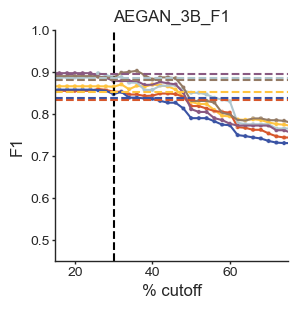

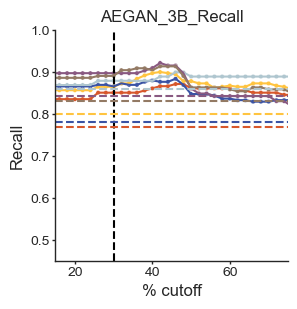

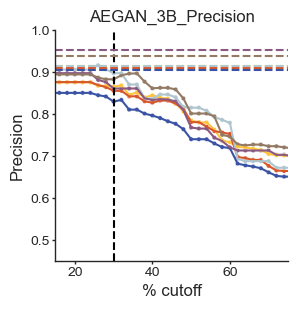

In [143]:
make_figure(df, x='% cutoff', y='F1', hue='Dataset', filename='AEGAN_3B_F1.svg')
make_figure(df, x='% cutoff', y='Recall', hue='Dataset', filename='AEGAN_3B_Recall.svg')
make_figure(df, x='% cutoff', y='Precision', hue='Dataset', filename='AEGAN_3B_Precision.svg')

In [144]:
df[df['% cutoff'] == 30]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
90,NN,30,0.852713,0.854922,0.850515,194,0.731481,0.250000,0.018519,0.822377
91,HA_superfamily,30,0.846975,0.829268,0.865455,275,0.697368,0.289474,0.013158,0.801974
92,PC,30,0.887755,0.896907,0.878788,99,0.763636,0.218182,0.018182,0.843939
93,EF_fold,30,0.878338,0.860465,0.896970,165,0.731183,0.258065,0.010753,0.822939
94,EF_superfamily,30,0.886364,0.882353,0.890411,219,0.772358,0.227642,0.000000,0.849458
95,EF_family,30,0.864499,0.864499,0.864499,369,0.760204,0.229592,0.010204,0.848299


In [145]:
df[df['% cutoff'] == 40]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
120,NN,40,0.843434,0.826733,0.860825,194,0.731481,0.250000,0.018519,0.830247
121,HA_superfamily,40,0.835924,0.796053,0.880000,275,0.684211,0.302632,0.013158,0.806360
122,PC,40,0.857143,0.836538,0.878788,99,0.745455,0.236364,0.018182,0.842727
123,EF_fold,40,0.869565,0.833333,0.909091,165,0.709677,0.279570,0.010753,0.819534
124,EF_superfamily,40,0.881960,0.860870,0.904110,219,0.739837,0.260163,0.000000,0.852304
125,EF_family,40,0.869908,0.844388,0.897019,369,0.755102,0.234694,0.010204,0.860046


In [146]:
rows = []
for squidly_cutoff in tqdm(range(0, 100, 2)):
    for df_label in results:
        if df_label == 'label':
            continue
        df = results[df_label]
        squidly_df = pd.read_pickle(f'data/AEGAN/squidly/squidly_as_pred_15B_{df_label.replace("_BLAST", "")}')
        squidly_df.set_index('label', inplace=True)
        df = df.join(squidly_df, how='left')
        # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
        tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
        precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
        rows.append([df_label.replace(".pkl", ""), squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


  2%|██▌                                                                                                                          | 1/50 [00:00<00:09,  5.03it/s]

You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0


  4%|█████                                                                                                                        | 2/50 [00:00<00:09,  5.05it/s]

[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0


  6%|███████▌                                                                                                                     | 3/50 [00:00<00:09,  5.05it/s]

[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0


  8%|██████████                                                                                                                   | 4/50 [00:00<00:09,  5.05it/s]

[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0


 10%|████████████▌                                                                                                                | 5/50 [00:00<00:08,  5.05it/s]

[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0


 12%|███████████████                                                                                                              | 6/50 [00:01<00:08,  5.06it/s]

[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 16%|████████████████████                                                                                                         | 8/50 [00:01<00:08,  5.06it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0


 18%|██████████████████████▌                                                                                                      | 9/50 [00:01<00:08,  5.06it/s]

[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0


 20%|████████████████████████▊                                                                                                   | 10/50 [00:01<00:07,  5.05it/s]

[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0


 22%|███████████████████████████▎                                                                                                | 11/50 [00:02<00:07,  5.04it/s]

[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0


 24%|█████████████████████████████▊                                                                                              | 12/50 [00:02<00:07,  5.05it/s]

[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0


 26%|████████████████████████████████▏                                                                                           | 13/50 [00:02<00:07,  5.06it/s]

[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99945801 0.87002653] 0.8700265251989391
You were missing N reference sequences: 0
[0.99940006 0.86437613] 0.864376130198915
You were missing N reference sequences: 0
[0.99955065 0.9015544 ] 0.9015544041450778
You were missing N reference sequences: 0
[0.9995743  0.90577508] 0.9057750759878421
You were missing N reference sequences: 0
[0.99952679 0.89655172] 0.896551724137931
You were missing N reference sequences: 0


 30%|█████████████████████████████████████▏                                                                                      | 15/50 [00:02<00:06,  5.07it/s]

[0.99946202 0.87534626] 0.8753462603878117
You were missing N reference sequences: 0
[0.99945801 0.87002653] 0.8700265251989391
You were missing N reference sequences: 0
[0.99940006 0.86437613] 0.864376130198915
You were missing N reference sequences: 0
[0.99955065 0.9015544 ] 0.9015544041450778
You were missing N reference sequences: 0
[0.9995743  0.90577508] 0.9057750759878421
You were missing N reference sequences: 0
[0.99952679 0.89655172] 0.896551724137931
You were missing N reference sequences: 0
[0.99946202 0.87534626] 0.8753462603878117
You were missing N reference sequences: 0


 32%|███████████████████████████████████████▋                                                                                    | 16/50 [00:03<00:06,  5.06it/s]

[0.99944694 0.86772487] 0.8677248677248677
You were missing N reference sequences: 0
[0.99939207 0.86231884] 0.8623188405797101
You were missing N reference sequences: 0
[0.99955065 0.9015544 ] 0.9015544041450778
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99952679 0.89655172] 0.896551724137931
You were missing N reference sequences: 0
[0.99946202 0.87534626] 0.8753462603878117
You were missing N reference sequences: 0
[0.99944694 0.86772487] 0.8677248677248677
You were missing N reference sequences: 0


 34%|██████████████████████████████████████████▏                                                                                 | 17/50 [00:03<00:06,  5.06it/s]

[0.99939205 0.86330935] 0.8633093525179856
You were missing N reference sequences: 0
[0.99955065 0.9015544 ] 0.9015544041450778
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99956884 0.90617849] 0.9061784897025171
You were missing N reference sequences: 0
[0.99947995 0.88      ] 0.8800000000000001
You were missing N reference sequences: 0
[0.99943587 0.86543536] 0.8654353562005278
You were missing N reference sequences: 0
[0.99934403 0.85357143] 0.8535714285714286
You were missing N reference sequences: 0


 36%|████████████████████████████████████████████▋                                                                               | 18/50 [00:03<00:06,  5.07it/s]

[0.99952699 0.89690722] 0.8969072164948454
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99957936 0.90825688] 0.908256880733945
You were missing N reference sequences: 0
[0.99943808 0.8715847 ] 0.871584699453552
You were missing N reference sequences: 0
[0.99943587 0.86543536] 0.8654353562005278
You were missing N reference sequences: 0
[0.99933603 0.85204991] 0.8520499108734403
You were missing N reference sequences: 0
[0.99952699 0.89690722] 0.8969072164948454
You were missing N reference sequences: 0


 38%|███████████████████████████████████████████████                                                                             | 19/50 [00:03<00:06,  5.07it/s]

[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99955831 0.90454545] 0.9045454545454545
You were missing N reference sequences: 0
[0.99947394 0.88010899] 0.8801089918256131
You were missing N reference sequences: 0
[0.9993916  0.85639687] 0.8563968668407311
You were missing N reference sequences: 0
[0.99932001 0.84955752] 0.8495575221238938
You were missing N reference sequences: 0
[0.99947966 0.8877551 ] 0.8877551020408163
You were missing N reference sequences: 0
[0.99949186 0.88955224] 0.8895522388059701
You were missing N reference sequences: 0


 40%|█████████████████████████████████████████████████▌                                                                          | 20/50 [00:03<00:05,  5.07it/s]

[0.99951624 0.8959276 ] 0.8959276018099547
You were missing N reference sequences: 0
[0.99944402 0.87483176] 0.8748317631224766
You were missing N reference sequences: 0
[0.99940265 0.859375  ] 0.8593750000000001
You were missing N reference sequences: 0
[0.99931999 0.85008818] 0.8500881834215167
You were missing N reference sequences: 0
[0.99947966 0.8877551 ] 0.8877551020408163
You were missing N reference sequences: 0
[0.99949185 0.89020772] 0.8902077151335313
You were missing N reference sequences: 0
[0.99947415 0.88789238] 0.8878923766816142
You were missing N reference sequences: 0


 44%|██████████████████████████████████████████████████████▌                                                                     | 22/50 [00:04<00:05,  5.08it/s]

[0.99946794 0.88021534] 0.8802153432032301
You were missing N reference sequences: 0
[0.99942477 0.86528497] 0.8652849740932643
You were missing N reference sequences: 0
[0.99928798 0.84358524] 0.843585237258348
You were missing N reference sequences: 0
[0.99952696 0.89795918] 0.8979591836734694
You were missing N reference sequences: 0
[0.99953304 0.89940828] 0.8994082840236686
You were missing N reference sequences: 0
[0.9995057  0.89485459] 0.8948545861297539
You were missing N reference sequences: 0
[0.99944998 0.87700535] 0.8770053475935828
You were missing N reference sequences: 0


 46%|█████████████████████████████████████████████████████████                                                                   | 23/50 [00:04<00:05,  5.08it/s]

[0.99942477 0.86528497] 0.8652849740932643
You were missing N reference sequences: 0
[0.99925596 0.83769634] 0.8376963350785339
You were missing N reference sequences: 0
[0.99952696 0.89795918] 0.8979591836734694
You were missing N reference sequences: 0
[0.99950558 0.89349112] 0.893491124260355
You were missing N reference sequences: 0
[0.99949518 0.89237668] 0.8923766816143498
You were missing N reference sequences: 0
[0.99943803 0.87433155] 0.8743315508021391
You were missing N reference sequences: 0
[0.99942475 0.86597938] 0.8659793814432989
You were missing N reference sequences: 0


 48%|███████████████████████████████████████████████████████████▌                                                                | 24/50 [00:04<00:05,  5.07it/s]

[0.99927195 0.84173913] 0.8417391304347827
You were missing N reference sequences: 0
[0.99952694 0.8989899 ] 0.898989898989899
You were missing N reference sequences: 0
[0.99949184 0.89085546] 0.8908554572271387
You were missing N reference sequences: 0
[0.99948466 0.89038031] 0.890380313199105
You were missing N reference sequences: 0
[0.99941411 0.86898396] 0.8689839572192514
You were missing N reference sequences: 0
[0.99938049 0.85641026] 0.8564102564102565
You were missing N reference sequences: 0
[0.99923195 0.83275261] 0.832752613240418
You were missing N reference sequences: 0


 50%|██████████████████████████████████████████████████████████████                                                              | 25/50 [00:04<00:04,  5.06it/s]

[0.9994323 0.88     ] 0.88
You were missing N reference sequences: 0
[0.99940945 0.87240356] 0.8724035608308605
You were missing N reference sequences: 0
[0.99937952 0.86681716] 0.8668171557562077
You were missing N reference sequences: 0
[0.99933641 0.85100671] 0.8510067114093959
You were missing N reference sequences: 0
[0.9992809 0.8346056] 0.8346055979643766
You were missing N reference sequences: 0
[0.99915995 0.81675393] 0.8167539267015708
You were missing N reference sequences: 0
[0.99933769 0.86      ] 0.86
You were missing N reference sequences: 0


 52%|████████████████████████████████████████████████████████████████▍                                                           | 26/50 [00:05<00:04,  5.07it/s]

[0.99931334 0.8502994 ] 0.8502994011976047
You were missing N reference sequences: 0
[0.99931644 0.85193622] 0.8519362186788154
You were missing N reference sequences: 0
[0.99930649 0.84574468] 0.8457446808510639
You were missing N reference sequences: 0
[0.9992809 0.8346056] 0.8346055979643766
You were missing N reference sequences: 0
[0.99915995 0.81675393] 0.8167539267015708
You were missing N reference sequences: 0
[0.99933769 0.86      ] 0.86
You were missing N reference sequences: 0
[0.99928587 0.84431138] 0.844311377245509
You were missing N reference sequences: 0


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 27/50 [00:05<00:04,  5.07it/s]

[0.9992954  0.84807256] 0.8480725623582767
You were missing N reference sequences: 0
[0.99928855 0.84196547] 0.8419654714475431
You were missing N reference sequences: 0
[0.99924769 0.82828283] 0.8282828282828284
You were missing N reference sequences: 0
[0.99915995 0.81675393] 0.8167539267015708
You were missing N reference sequences: 0
[0.99929034 0.85148515] 0.8514851485148516
You were missing N reference sequences: 0
[0.99925838 0.83928571] 0.8392857142857144
You were missing N reference sequences: 0
[0.99925333 0.83900227] 0.8390022675736961
You were missing N reference sequences: 0


 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 29/50 [00:05<00:04,  5.07it/s]

[0.99925865 0.83554377] 0.8355437665782494
You were missing N reference sequences: 0
[0.99922554 0.8241206 ] 0.8241206030150755
You were missing N reference sequences: 0
[0.99912795 0.80977312] 0.8097731239092496
You were missing N reference sequences: 0
[0.99926667 0.84729064] 0.8472906403940886
You were missing N reference sequences: 0
[0.99923092 0.83333333] 0.8333333333333334
You were missing N reference sequences: 0
[0.99923228 0.83521445] 0.835214446952596
You were missing N reference sequences: 0
[0.9991869  0.81962865] 0.8196286472148542


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 30/50 [00:05<00:03,  5.05it/s]

You were missing N reference sequences: 0
[0.99921447 0.82205514] 0.8220551378446116
You were missing N reference sequences: 0
[0.99910396 0.8041958 ] 0.8041958041958043
You were missing N reference sequences: 0
[0.99926667 0.84729064] 0.8472906403940886
You were missing N reference sequences: 0
[0.99920343 0.82840237] 0.8284023668639054
You were missing N reference sequences: 0
[0.9991586  0.82222222] 0.8222222222222222
You were missing N reference sequences: 0
[0.99915099 0.81364829] 0.8136482939632547
You were missing N reference sequences: 0


 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 31/50 [00:06<00:03,  5.06it/s]

[0.9992034 0.82     ] 0.82
You were missing N reference sequences: 0
[0.99909595 0.80279232] 0.8027923211169284
You were missing N reference sequences: 0
[0.999243   0.84313725] 0.8431372549019608
You were missing N reference sequences: 0
[0.99916219 0.82111437] 0.8211143695014661
You were missing N reference sequences: 0
[0.99912704 0.81596452] 0.8159645232815965
You were missing N reference sequences: 0
[0.99913901 0.81201044] 0.8120104438642297
You were missing N reference sequences: 0
[0.9990816  0.79706601] 0.7970660146699265
You were missing N reference sequences: 0


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 32/50 [00:06<00:03,  5.06it/s]

[0.99902388 0.79037801] 0.7903780068728522
You were missing N reference sequences: 0
[0.99907725 0.81516588] 0.8151658767772512
You were missing N reference sequences: 0
[0.9991072 0.8115942] 0.8115942028985507
You were missing N reference sequences: 0
[0.99906388 0.80525164] 0.8052516411378556
You were missing N reference sequences: 0
[0.99910909 0.80674449] 0.8067444876783398
You were missing N reference sequences: 0
[0.99907053 0.79512195] 0.7951219512195122
You were missing N reference sequences: 0
[0.99901587 0.7890223 ] 0.7890222984562607
You were missing N reference sequences: 0


 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 33/50 [00:06<00:03,  5.07it/s]

[0.99907725 0.81516588] 0.8151658767772512
You were missing N reference sequences: 0
[0.9991072 0.8115942] 0.8115942028985507
You were missing N reference sequences: 0
[0.99906388 0.80525164] 0.8052516411378556
You were missing N reference sequences: 0
[0.99910909 0.80674449] 0.8067444876783398
You were missing N reference sequences: 0
[0.99905945 0.79318735] 0.7931873479318734
You were missing N reference sequences: 0
[0.99900786 0.78767123] 0.7876712328767125
You were missing N reference sequences: 0
[0.99907725 0.81516588] 0.8151658767772512
You were missing N reference sequences: 0


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 34/50 [00:06<00:03,  5.06it/s]

[0.9991072 0.8115942] 0.8115942028985507
You were missing N reference sequences: 0
[0.99908489 0.81045752] 0.8104575163398693
You were missing N reference sequences: 0
[0.99913299 0.81290323] 0.8129032258064516
You were missing N reference sequences: 0
[0.99905945 0.79318735] 0.7931873479318734
You were missing N reference sequences: 0
[0.99900786 0.78767123] 0.7876712328767125
You were missing N reference sequences: 0
[0.99907725 0.81516588] 0.8151658767772512
You were missing N reference sequences: 0
[0.9991072 0.8115942] 0.8115942028985507


 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 35/50 [00:06<00:02,  5.04it/s]

You were missing N reference sequences: 0
[0.99908489 0.81045752] 0.8104575163398693
You were missing N reference sequences: 0
[0.999127   0.81185567] 0.8118556701030928
You were missing N reference sequences: 0
[0.99900407 0.78365385] 0.7836538461538463
You were missing N reference sequences: 0
[0.99897582 0.78231293] 0.782312925170068
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99909346 0.80924855] 0.8092485549132948
You were missing N reference sequences: 0


 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 36/50 [00:07<00:02,  5.02it/s]

[0.99907437 0.80869565] 0.8086956521739131
You were missing N reference sequences: 0
[0.99908512 0.80409731] 0.8040973111395646
You were missing N reference sequences: 0
[0.99898192 0.77990431] 0.7799043062200958
You were missing N reference sequences: 0
[0.99893575 0.77647059] 0.776470588235294
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99905221 0.80229226] 0.8022922636103152
You were missing N reference sequences: 0
[0.99906384 0.80694143] 0.806941431670282


 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 37/50 [00:07<00:02,  5.03it/s]

You were missing N reference sequences: 0
[0.99906716 0.80102041] 0.8010204081632654
You were missing N reference sequences: 0
[0.99898192 0.77990431] 0.7799043062200958
You were missing N reference sequences: 0
[0.99892776 0.77441077] 0.7744107744107744
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99905221 0.80229226] 0.8022922636103152
You were missing N reference sequences: 0
[0.99906384 0.80694143] 0.806941431670282
You were missing N reference sequences: 0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 39/50 [00:07<00:02,  5.05it/s]

[0.99906118 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0
[0.99898192 0.77990431] 0.7799043062200958
You were missing N reference sequences: 0
[0.99892776 0.77441077] 0.7744107744107744
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0
[0.9990552  0.79846939] 0.7984693877551019
You were missing N reference sequences: 0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 40/50 [00:07<00:01,  5.04it/s]

[0.99898192 0.77990431] 0.7799043062200958
You were missing N reference sequences: 0
[0.99891977 0.77234401] 0.7723440134907252
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0
[0.99904325 0.79591837] 0.7959183673469388
You were missing N reference sequences: 0
[0.99894868 0.77434679] 0.7743467933491686
You were missing N reference sequences: 0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 41/50 [00:08<00:01,  5.04it/s]

[0.99890376 0.76897133] 0.7689713322091063
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0
[0.99903726 0.79490446] 0.794904458598726
You were missing N reference sequences: 0
[0.99893763 0.77142857] 0.7714285714285714
You were missing N reference sequences: 0
[0.99889577 0.76689189] 0.7668918918918919
You were missing N reference sequences: 0


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 42/50 [00:08<00:01,  5.01it/s]

[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0
[0.99903726 0.79490446] 0.794904458598726
You were missing N reference sequences: 0
[0.99893763 0.77142857] 0.7714285714285714
You were missing N reference sequences: 0
[0.99888776 0.76559865] 0.7655986509274874
You were missing N reference sequences: 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 43/50 [00:08<00:01,  5.01it/s]

[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0
[0.99903127 0.79389313] 0.7938931297709925
You were missing N reference sequences: 0
[0.99893763 0.77142857] 0.7714285714285714
You were missing N reference sequences: 0
[0.99887174 0.76302521] 0.7630252100840337
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/50 [00:08<00:01,  5.02it/s]

[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0
[0.9990193  0.79187817] 0.7918781725888325
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99886375 0.76094276] 0.760942760942761
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99901102 0.79310345] 0.793103448275862
You were missing N reference sequences: 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 45/50 [00:08<00:00,  5.03it/s]

[0.99903229 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0
[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99886375 0.76094276] 0.760942760942761
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99901102 0.79310345] 0.793103448275862
You were missing N reference sequences: 0
[0.99903229 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 47/50 [00:09<00:00,  5.04it/s]

[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99886375 0.76094276] 0.760942760942761
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99901102 0.79310345] 0.793103448275862
You were missing N reference sequences: 0
[0.99903229 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0
[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48/50 [00:09<00:00,  5.03it/s]

[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99886375 0.76094276] 0.760942760942761
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99899727 0.79083095] 0.7908309455587391
You were missing N reference sequences: 0
[0.99902176 0.79826464] 0.7982646420824294
You were missing N reference sequences: 0
[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49/50 [00:09<00:00,  5.01it/s]

You were missing N reference sequences: 0
[0.99885573 0.75966387] 0.7596638655462185
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99899727 0.79083095] 0.7908309455587391
You were missing N reference sequences: 0
[0.99902176 0.79826464] 0.7982646420824294
You were missing N reference sequences: 0
[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.05it/s]

[0.99885573 0.75966387] 0.7596638655462185
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99899727 0.79083095] 0.7908309455587391
You were missing N reference sequences: 0
[0.99902176 0.79826464] 0.7982646420824294
You were missing N reference sequences: 0
[0.99900136 0.78833967] 0.7883396704689482


In [147]:
df = pd.DataFrame(rows, columns=['Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support', '% fully correct', ' % with difference', ' % missing', 'Mean correct'])
df.to_csv('data/Ensemble_Squidly_15B.csv', index=False)

In [148]:
df['Dataset'] = [d.replace('_BLAST', '') for d in df['Dataset'].values]

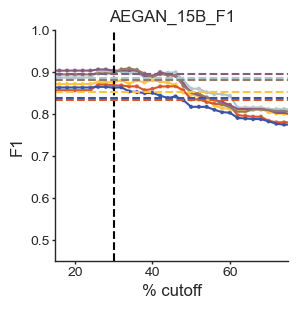

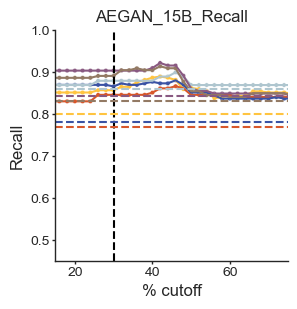

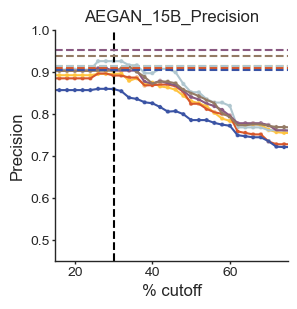

In [149]:
make_figure(df, x='% cutoff', y='F1', hue='Dataset', filename='AEGAN_15B_F1.svg')
make_figure(df, x='% cutoff', y='Recall', hue='Dataset', filename='AEGAN_15B_Recall.svg')
make_figure(df, x='% cutoff', y='Precision', hue='Dataset', filename='AEGAN_15B_Precision.svg')

In [150]:
df[df['% cutoff'] == 30]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
90,NN,30,0.867725,0.891304,0.845361,194,0.750000,0.212963,0.037037,0.829475
91,HA_superfamily,30,0.862319,0.859206,0.865455,275,0.736842,0.230263,0.032895,0.816557
92,PC,30,0.901554,0.925532,0.878788,99,0.818182,0.163636,0.018182,0.860606
93,EF_fold,30,0.903030,0.903030,0.903030,165,0.774194,0.204301,0.021505,0.848566
94,EF_superfamily,30,0.896552,0.902778,0.890411,219,0.788618,0.186992,0.024390,0.853659
95,EF_family,30,0.875346,0.895184,0.856369,369,0.775510,0.198980,0.025510,0.851616


In [151]:
df[df['% cutoff'] == 0]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
0,NN,0,0.856383,0.884615,0.829897,194,0.750000,0.222222,0.027778,0.824846
1,HA_superfamily,0,0.862816,0.856631,0.869091,275,0.743421,0.236842,0.019737,0.823136
2,PC,0,0.886598,0.905263,0.868687,99,0.800000,0.200000,0.000000,0.851515
3,EF_fold,0,0.903030,0.903030,0.903030,165,0.784946,0.204301,0.010753,0.853943
4,EF_superfamily,0,0.894009,0.902326,0.885845,219,0.788618,0.186992,0.024390,0.852304
5,EF_family,0,0.871012,0.892045,0.850949,369,0.770408,0.204082,0.025510,0.847364
